# Welcome to Philip's second EDA 
## The effect of risk perception on house prices. Comparing FLorida to New York

### Purpose of this EDA: 
- Explore house price format and granularity
- Merge with FIRM and SFHA data
- Investigate possible identification strategies? 

In [1]:
# data handling 
import pandas as pd
import numpy as np

# geospatial handling
import geopandas as gpd
import contextily as cx
import osmnx as ox

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

links: 
https://www.zillow.com/research/data/
https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=ZIP+Code+Tabulation+Areas
https://catalog.data.gov/dataset/reserve-special-flood-hazard-areas-sfha

In [2]:
path = "/Users/philip/Documents/ESE/ESE_thesis/flood_experience/data/houseprices/Neighborhood.csv"
neighborhoods = pd.read_csv(path)
neighborhoods.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31
0,112345,0,Maryvale,neighborhood,AZ,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,67243.870428,...,3.382969e+05,3.397157e+05,3.406742e+05,3.410846e+05,3.410132e+05,3.402700e+05,3.391275e+05,3.379589e+05,3.371738e+05,3.360984e+05
1,192689,1,Paradise,neighborhood,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,131781.521430,...,3.784336e+05,3.810294e+05,3.834767e+05,3.856604e+05,3.873501e+05,3.885882e+05,3.894825e+05,3.906129e+05,3.920937e+05,3.933752e+05
2,270958,2,Upper West Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,375159.910493,...,1.151754e+06,1.149559e+06,1.149639e+06,1.153582e+06,1.162458e+06,1.167099e+06,1.170985e+06,1.183286e+06,1.201208e+06,1.216508e+06
3,270957,3,Upper East Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,615899.244168,...,1.149472e+06,1.146475e+06,1.144932e+06,1.146691e+06,1.152861e+06,1.155846e+06,1.157616e+06,1.168824e+06,1.185831e+06,1.200718e+06
4,118208,4,South Los Angeles,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,127688.167292,...,6.514779e+05,6.514456e+05,6.517074e+05,6.542784e+05,6.594266e+05,6.659181e+05,6.712271e+05,6.749033e+05,6.775716e+05,6.760528e+05


In [3]:
neighborhoods.shape

(21635, 310)

In [4]:
path = "/Users/philip/Documents/ESE/ESE_thesis/flood_experience/data/houseprices/zip_code.csv"
zipcodes = pd.read_csv(path)
zipcodes.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,209050.476760,...,493768.795807,495075.413843,495380.402566,495002.983332,495408.561941,496096.305465,497215.161891,497931.319966,498348.024838,498770.070517
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,129618.780605,...,567181.889516,574111.688523,579228.585853,583825.798950,588765.877710,594583.485735,599788.275075,603106.031473,605075.749335,605701.713141
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103655.528341,...,281613.081259,282147.022097,282107.280779,281872.890421,281691.186379,281502.991848,281086.410278,280298.902221,279570.221742,278960.087685
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,146323.411563,...,448237.173500,452805.954270,453500.452732,452997.379756,452371.998659,453320.495788,453075.343776,451863.571974,449627.300182,447532.075931
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,102106.861831,...,274112.517554,274613.196678,274446.918170,274155.370186,273883.459171,273631.254558,273125.765642,272528.815424,272190.921082,271949.294782


In [5]:
zipcodes.shape

(26323, 310)

zipcodes > neighborhoods. proceed with zipcodes

In [6]:
# lets recode zipcodes as string and fill up leading zeros that have gone missing 
zipcodes.RegionName = zipcodes.RegionName.astype('string')

for i in zipcodes.index: 
    if len(zipcodes.at[i,'RegionName']) == 4: 
        zipcodes.at[i,'RegionName'] = str(0) + zipcodes.at[i,'RegionName']
    if len(zipcodes.at[i,'RegionName']) <= 4:
        print(i)
# classic lets try shit and pray loop... Make sure we fetched all exceptions...

In [7]:
zipcodes.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,209050.476760,...,493768.795807,495075.413843,495380.402566,495002.983332,495408.561941,496096.305465,497215.161891,497931.319966,498348.024838,498770.070517
1,61148,2,08701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,129618.780605,...,567181.889516,574111.688523,579228.585853,583825.798950,588765.877710,594583.485735,599788.275075,603106.031473,605075.749335,605701.713141
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103655.528341,...,281613.081259,282147.022097,282107.280779,281872.890421,281691.186379,281502.991848,281086.410278,280298.902221,279570.221742,278960.087685
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,146323.411563,...,448237.173500,452805.954270,453500.452732,452997.379756,452371.998659,453320.495788,453075.343776,451863.571974,449627.300182,447532.075931
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,102106.861831,...,274112.517554,274613.196678,274446.918170,274155.370186,273883.459171,273631.254558,273125.765642,272528.815424,272190.921082,271949.294782


In [8]:
# Let's merge with shapefiles
path = "/Users/philip/Documents/ESE/ESE_thesis/flood_experience/data/tl_2024_us_zcta520/tl_2024_us_zcta520.shx"
gdf = gpd.read_file(path)

In [9]:
gdf.ZCTA5CE20

0        47236
1        47870
2        47851
3        47337
4        47435
         ...  
33786    37932
33787    37341
33788    37849
33789    37754
33790    37806
Name: ZCTA5CE20, Length: 33791, dtype: object

In [10]:
gdf = gdf.merge(zipcodes, left_on='ZCTA5CE20', right_on='RegionName', how='right')

<Axes: >

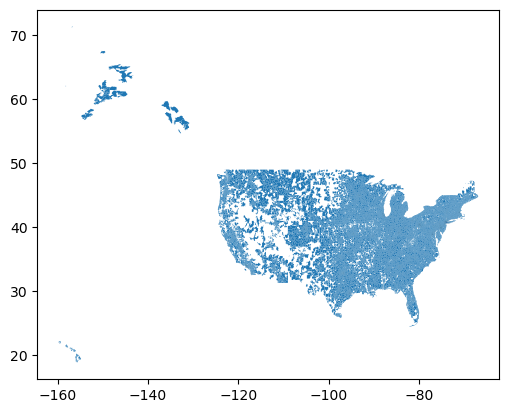

In [11]:
gdf.plot()

<Axes: >

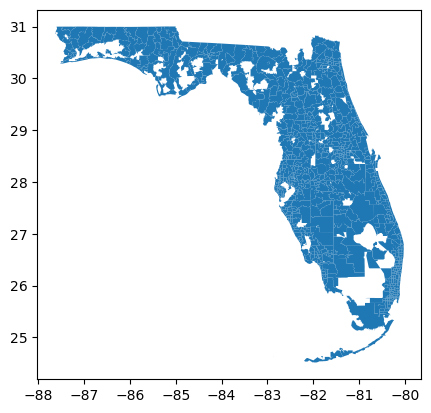

In [27]:
gdf[gdf['State'] == 'FL'].plot()

<Axes: >

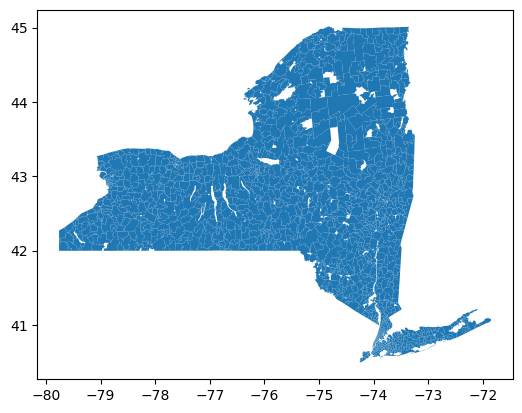

In [28]:
gdf[gdf['State'] == 'NY'].plot()